In [94]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [95]:
# Display versions
print("📦 Library Versions")
print(f"NumPy version        : {np.__version__}")
print(f"Pandas version       : {pd.__version__}")
print(f"Missingno version    : {msno.__version__}")
import sklearn
print(f"scikit-learn version : {sklearn.__version__}")

📦 Library Versions
NumPy version        : 1.26.4
Pandas version       : 2.2.3
Missingno version    : 0.5.2
scikit-learn version : 1.2.2


In [96]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')

/tmp/ipykernel_36/2910231406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')


In [97]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [98]:
users.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [99]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [100]:
print(books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


<Axes: >

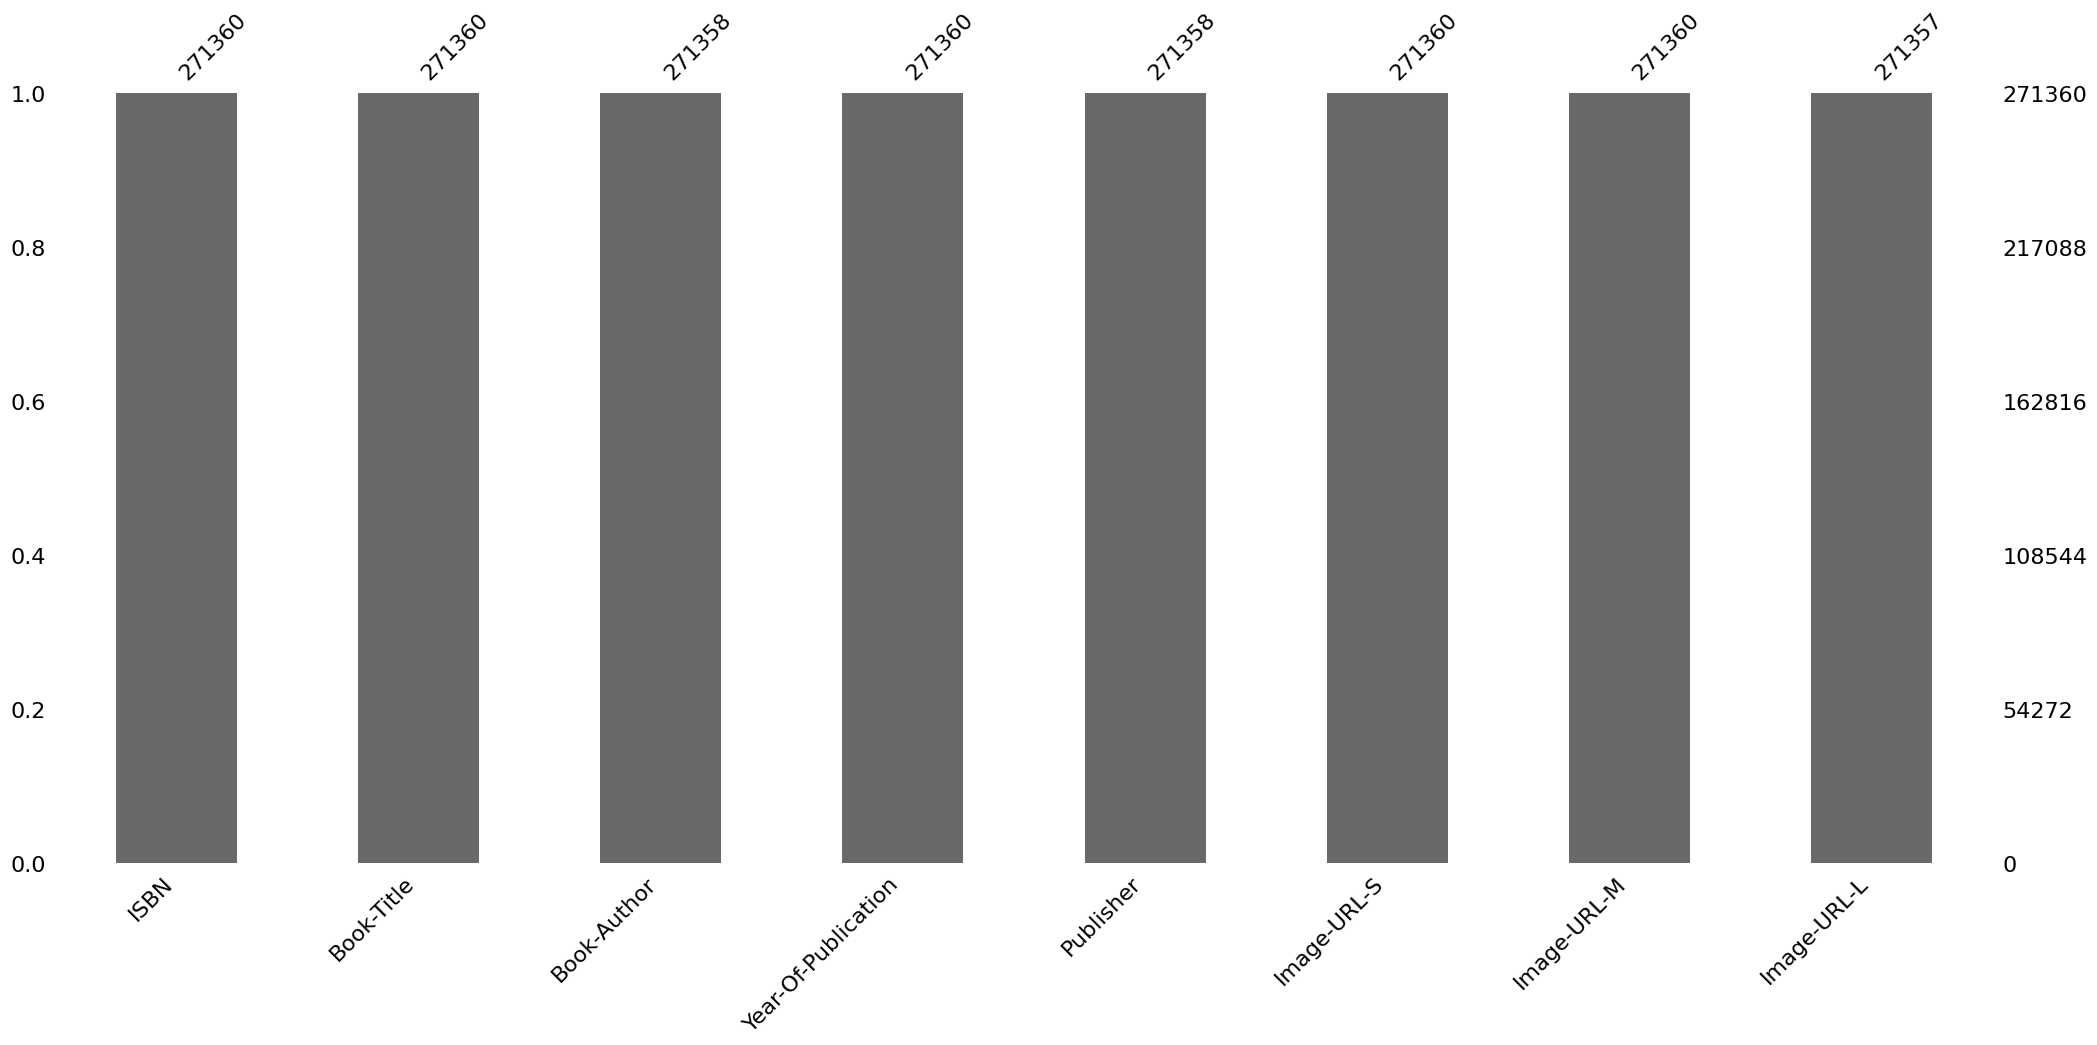

In [101]:
msno.bar(books)

<Axes: >

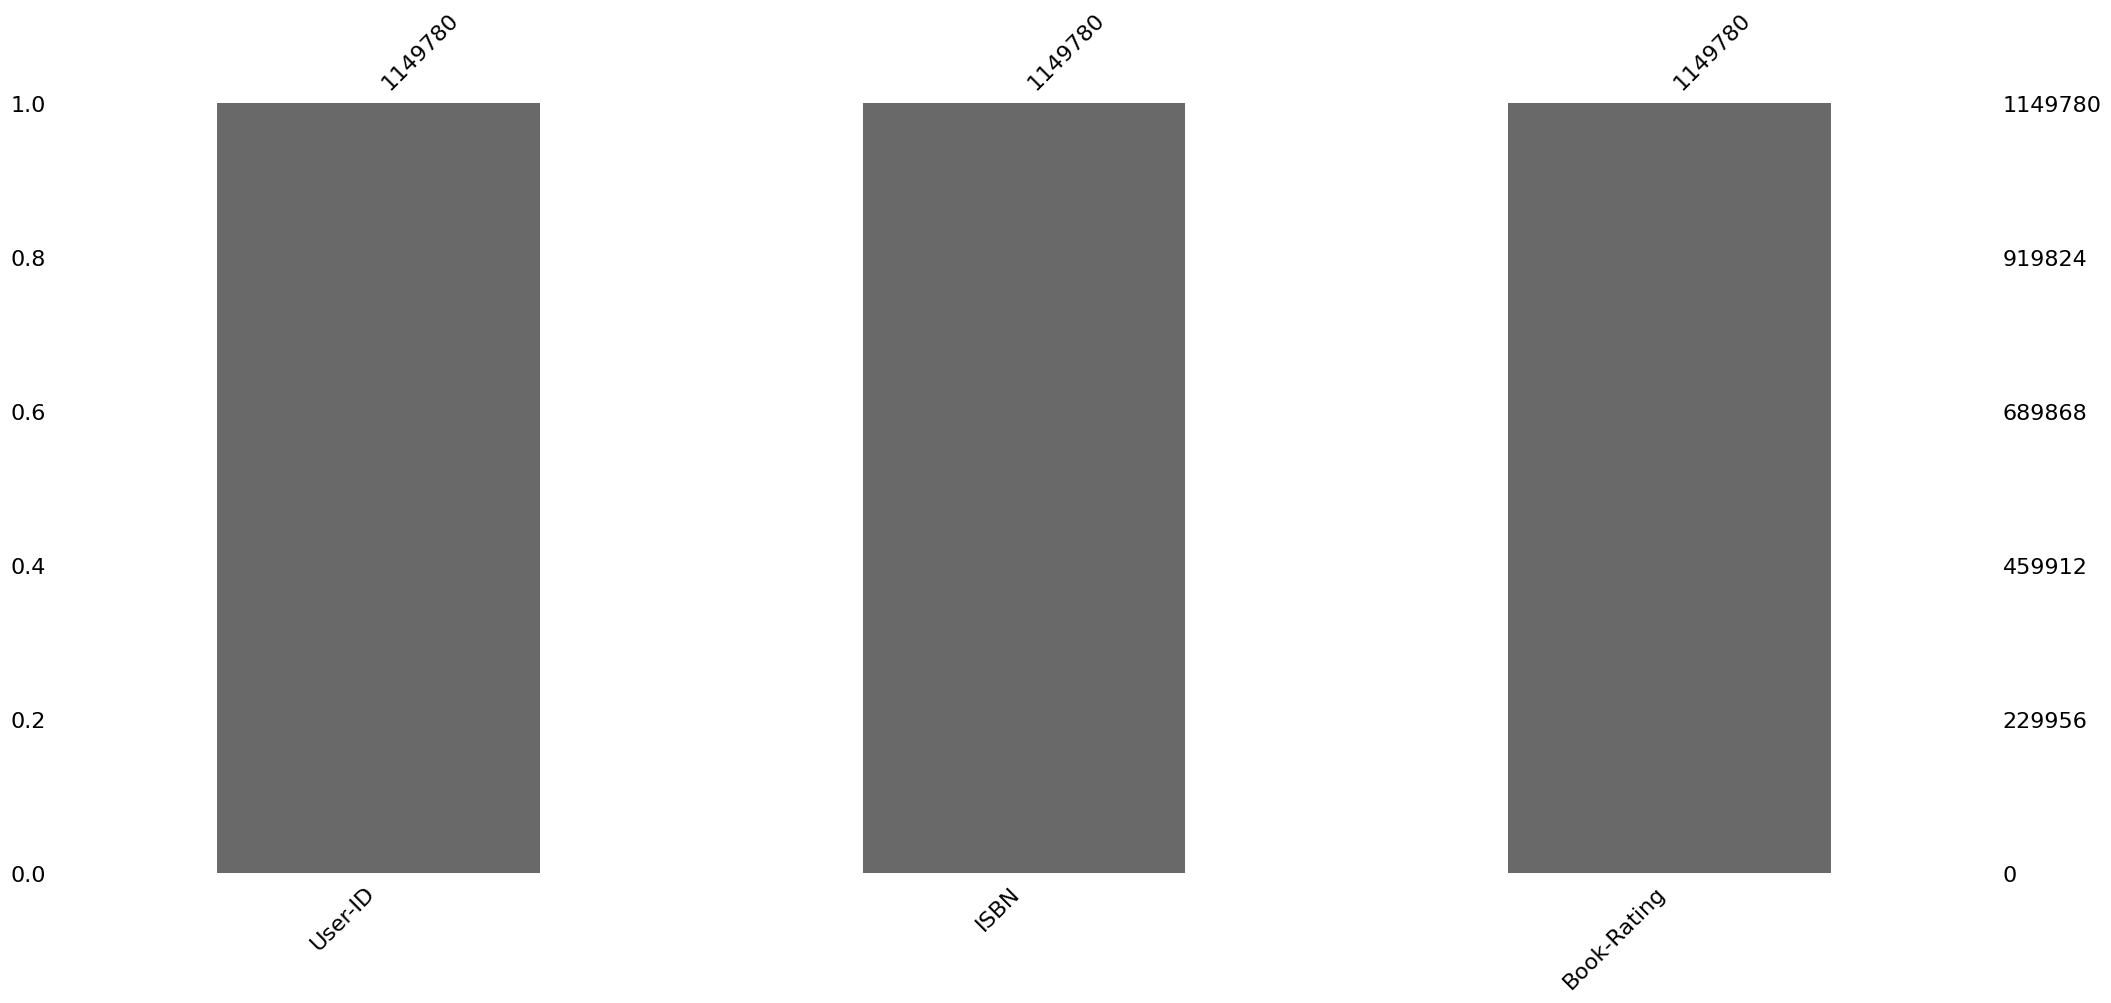

In [102]:
msno.bar(ratings)

<Axes: >

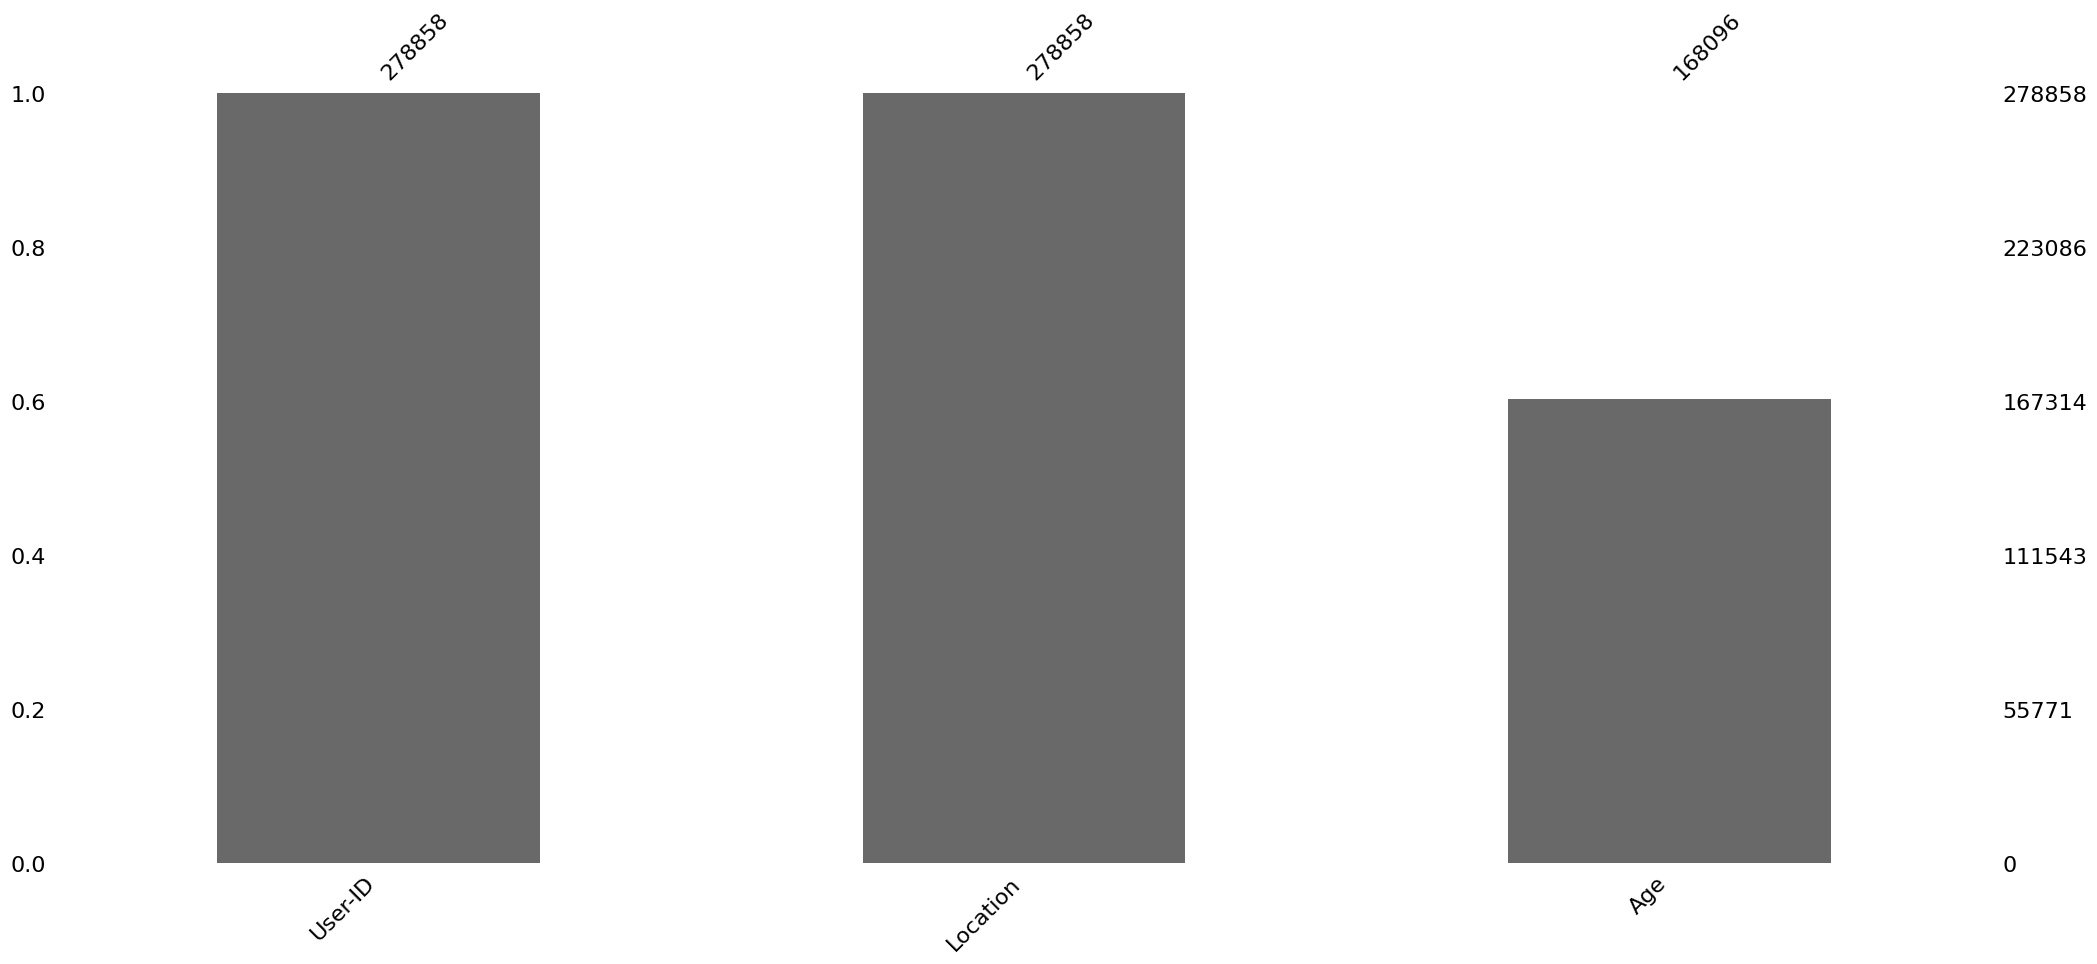

In [103]:
msno.bar(users)

## **Data Preprocessing**

#### Handling Missing Values

In [104]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [105]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [106]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

#### Remove Duplicates

In [107]:
books.duplicated().sum()

0

In [108]:
users.duplicated().sum()

0

In [109]:
ratings.duplicated().sum()

0

## **Popularity Based Recommender System**

In [110]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [111]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [112]:
ratings.merge(books,on='ISBN').head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [113]:
ratings_with_name = ratings.merge(books,on = 'ISBN')

In [114]:
ratings_with_name.shape

(1031136, 10)

In [115]:
ratings_with_name.groupby('Book-Title').count()

,User-ID,ISBN,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
Book-Title,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",4,4,4,4,4,4,4,4,4
Always Have Popsicles,1,1,1,1,1,1,1,1,1
Apple Magic (The Collector's series),1,1,1,1,1,1,1,1,1
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",1,1,1,1,1,1,1,1,1
Beyond IBM: Leadership Marketing and Finance for the 1990s,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
Ã?Â?lpiraten.,2,2,2,2,2,2,2,2,2
Ã?Â?rger mit Produkt X. Roman.,4,4,4,4,4,4,4,4,4
Ã?Â?sterlich leben.,1,1,1,1,1,1,1,1,1


In [116]:
num_rating_df = (
    ratings_with_name.groupby('Book-Title')['Book-Rating']
    .count()
    .reset_index()
    .rename(columns={'Book-Rating': 'num_ratings'})
)

num_rating_df.head()

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [117]:
avg_rating_df = (
    ratings_with_name.groupby('Book-Title')['Book-Rating']
    .mean()
    .reset_index()
    .rename(columns={'Book-Rating': 'avg_ratings'})
)
avg_rating_df.head()

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00
2,Apple Magic (The Collector's series),0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.00
4,Beyond IBM: Leadership Marketing and Finance ...,0.00


In [118]:
popular_df = num_rating_df.merge(avg_rating_df, on='Book-Title')
popular_df.head()

,Book-Title,num_ratings,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00


In [119]:
popular_df.shape

(241071, 3)

In [120]:
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_ratings', ascending = False).head(50)

In [121]:
popular_df.shape

(50, 3)

In [122]:
merged_df = popular_df.merge(books, on='Book-Title')
merged_df.head()

,Book-Title,num_ratings,avg_ratings,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136350,J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
1,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136369,J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...
2,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0786222743,J. K. Rowling,2000,Thorndike Press,http://images.amazon.com/images/P/0786222743.0...,http://images.amazon.com/images/P/0786222743.0...,http://images.amazon.com/images/P/0786222743.0...
3,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139597,J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
4,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139600,J. K. Rowling,2002,Scholastic Paperbacks,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...


In [123]:
unique_books_df = merged_df.drop_duplicates('Book-Title')
unique_books_df.head()


,Book-Title,num_ratings,avg_ratings,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136350,J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
3,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139597,J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
5,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410,0590353403,J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
9,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441,043935806X,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...
13,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453,0439064872,J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...


In [124]:
popular_df = unique_books_df[['Book-Title', 'Book-Author', 'Image-URL-M', 'num_ratings', 'avg_ratings']]
popular_df.head()

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453


In [125]:
popular_df

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.880769
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.700000


## **Collaborative Filtering Based Recommender System**

In [126]:
# Count ratings per user
user_rating_counts = ratings_with_name.groupby('User-ID')['Book-Rating'].count()
user_rating_counts.head()

User-ID
2      1
8     17
9      3
10     1
12     1
Name: Book-Rating, dtype: int64

In [127]:
# Filter users with more than 200 ratings
active_users = user_rating_counts[user_rating_counts > 200].index
active_users[:10]  # show first 10 active users

Index([254, 2276, 2766, 2977, 3363, 4017, 4385, 6251, 6323, 6543], dtype='int64', name='User-ID')

In [128]:
# Filter the ratings dataset
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(active_users)]
filtered_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1151,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,1995,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...,http://images.amazon.com/images/P/0026217457.0...,http://images.amazon.com/images/P/0026217457.0...
1152,277427,003008685X,8,Pioneers,James Fenimore Cooper,1974,Thomson Learning,http://images.amazon.com/images/P/003008685X.0...,http://images.amazon.com/images/P/003008685X.0...,http://images.amazon.com/images/P/003008685X.0...
1153,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",G. B. Trudeau,1982,Henry Holt &amp; Co,http://images.amazon.com/images/P/0030615321.0...,http://images.amazon.com/images/P/0030615321.0...,http://images.amazon.com/images/P/0030615321.0...
1154,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),Stephanie Laurens,2002,Avon Books,http://images.amazon.com/images/P/0060002050.0...,http://images.amazon.com/images/P/0060002050.0...,http://images.amazon.com/images/P/0060002050.0...


In [129]:
filtered_rating.shape

(474007, 10)

In [130]:
# Count ratings per book
book_rating_counts = filtered_rating.groupby('Book-Title')['Book-Rating'].count()
book_rating_counts.head()

Book-Title
A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)    2
Always Have Popsicles                                                                                        1
Apple Magic (The Collector's series)                                                                         1
Beyond IBM: Leadership Marketing and Finance for the 1990s                                                   1
Clifford Visita El Hospital (Clifford El Gran Perro Colorado)                                                1
Name: Book-Rating, dtype: int64

In [131]:
# Keep books with at least 50 ratings
famous_books = book_rating_counts[book_rating_counts >= 50].index
famous_books[:10]  # show first 10

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance'],
      dtype='object', name='Book-Title')

In [132]:
# Filter the dataset for only these books
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]
final_ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1163,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
1165,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...
1168,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...
1174,277427,006440188X,0,The Secret Garden,Frances Hodgson Burnett,1998,HarperTrophy,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...,http://images.amazon.com/images/P/006440188X.0...


In [133]:
final_ratings.shape

(58586, 10)

In [134]:
# pivot table
pt = final_ratings.pivot_table(
    index='Book-Title',       # rows = books
    columns='User-ID',        # columns = users
    values='Book-Rating',     # values = ratings
)

pt.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# Handle missing values
pt = pt.fillna(0)
pt.head()

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
pt.shape

(706, 810)

In [137]:
# Compute cosine similarity between books
similarity_matrix = cosine_similarity(pt)

similarity_matrix.shape

(706, 706)

In [138]:
def recommend(book_name, n=5):
    # find the index of the given book
    book_index = pt.index.get_loc(book_name)
    
    # get similarity scores for this book
    similarity_scores = list(enumerate(similarity_matrix[book_index]))
    
    # sort by similarity score (skip the book itself)
    similar_items = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    data = []
    # print recommended books
    for i in similar_items:
        #print(pt.index[i[0]])
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

        data.append(item)

    return data


In [139]:
recommend('The Da Vinci Code')

[['Angels &amp; Demons',
  'Dan Brown',
  'http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg'],
 ['Touching Evil',
  'Kay Hooper',
  'http://images.amazon.com/images/P/0553583441.01.MZZZZZZZ.jpg'],
 ['Saving Faith',
  'David Baldacci',
  'http://images.amazon.com/images/P/0446608890.01.MZZZZZZZ.jpg'],
 ["The Sweet Potato Queens' Book of Love",
  'JILL CONNER BROWNE',
  'http://images.amazon.com/images/P/0609804138.01.MZZZZZZZ.jpg'],
 ['Middlesex: A Novel',
  'Jeffrey Eugenides',
  'http://images.amazon.com/images/P/0312422156.01.MZZZZZZZ.jpg']]

In [140]:
# Save DataFrames and similarity matrix as .pkl files
with open('popular_df.pkl', 'wb') as file:
    pickle.dump(popular_df, file)

with open('pt.pkl', 'wb') as file:
    pickle.dump(pt, file)

with open('books.pkl', 'wb') as file:
    pickle.dump(books, file)

with open('similarity_matrix.pkl', 'wb') as file:
    pickle.dump(similarity_matrix, file)

print("✅ All pickle files saved successfully!")


✅ All pickle files saved successfully!
